<a href="https://colab.research.google.com/github/Delaunay-I/image_cap_generator/blob/main/cap_gen_v3_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## for google colab runs
%cd /content/drive/MyDrive/colab\ files
%pwd

/content/drive/MyDrive/colab files


'/content/drive/MyDrive/colab files'

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import re, sys, os
import numpy as np

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

python 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
keras version 2.12.0
tensorflow version 2.12.0


In [4]:
IMAGES_PATH="flickr8k/Images"
TEXT_PATH = "flickr8k/Flickr8k.token.txt"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 4000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 1280

# Per-layer units in the feed-forward network
FF_DIM = 1024

# Other training parameters
BATCH_SIZE = 10
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "startseq " + caption.strip() + " endseq"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

In [6]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data(TEXT_PATH)

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


In [7]:
def custom_standardization(input_string):

    lowercase = tf.strings.lower(input_string)
    lowercase = tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")
    return lowercase


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")


tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)

tokenizer.adapt(text_data)
if len(tokenizer.get_vocabulary()) < VOCAB_SIZE:
    VOCAB_SIZE = len(tokenizer.get_vocabulary())
print(VOCAB_SIZE)

4000


Preprocess image

In [8]:
# Data augmentation for image data
image_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), tokenizer(captions)

## Make dataset

In [9]:
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [15]:
ss = next(iter(train_dataset))

In [43]:
tf.shape(ss[1]).numpy()

array([10,  5, 25], dtype=int32)

In [31]:
ss[1].shape

TensorShape([10, 5, 25])

# Define the model

cnn model

In [34]:

from keras.applications import EfficientNetV2M

def get_cnn_model():
    base_model = EfficientNetV2M(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights='imagenet'
        )

    # Freeze feature extractor layers
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out) # shape: (batch_size, 1, max_image_feats=2048 for inceptionV3)
    cnn_model = tf.keras.models.Model(base_model.input, base_model_out)

    return cnn_model

Attention sub-layers

In [35]:
class AoA_layer(layers.Layer):
    def __init__(self, embed_dim, dropout_rate=0.3):
        super().__init__()
        self.dropout = layers.Dropout(dropout_rate)
        self.attention_gate_layer = layers.Dense(units=embed_dim, activation='sigmoid')
        self.info_vec_layer = layers.Dense(units=embed_dim, activation=None)

    def call(self, query, attention_out, training):
        input = tf.concat([query, attention_out], axis=-1)
        input = self.dropout(input, training=training)

        G = self.attention_gate_layer(input)
        I = self.info_vec_layer(input)

        return tf.multiply(I, G)

In [36]:
class Encoder_refining_layer(tf.keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, dropout_rate):
        super().__init__()
        self.dense_q = layers.Dense(units=embed_dim, activation=None)
        self.dense_v = layers.Dense(units=embed_dim, activation=None)
        self.dense_k = layers.Dense(units=embed_dim, activation=None)

        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.aoa_refiner = AoA_layer(embed_dim)
        self.layernorm = layers.LayerNormalization()

    def call(self, image_feat, training):
        Q = self.dense_q(image_feat)
        V = self.dense_v(image_feat)
        K = self.dense_k(image_feat)

        attention_res = self.mha(
            query=Q,
            value=V,
            key=K,
            attention_mask=None,
            training=training,
        )
        Ihat = self.aoa_refiner(query=Q, attention_out=attention_res, training=training)

        return self.layernorm(Ihat + image_feat)


In [37]:
class Image_Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, embed_dim, num_heads, dropout_rate=0.1):
        super().__init__()
        self.num_layers = num_layers
        self.enc_layers = [
            Encoder_refining_layer(
                num_heads=num_heads, embed_dim=embed_dim, dropout_rate=dropout_rate
                )
            for _ in range(num_layers)]

    def call(self, inputs, training):
        for i in range(self.num_layers):
            x = self.enc_layers[i](inputs, training)

        return x


Decoder

In [38]:
class DecoderAoALayer(layers.Layer):
    def __init__(self, embed_dim, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.embed_dim = embed_dim

        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.lstm = layers.LSTMCell(units=embed_dim)
        self.attention = layers.MultiHeadAttention(num_heads=1, key_dim=embed_dim, dropout=dropout_rate)

        self.aoa_refiner = AoA_layer(embed_dim)
        self.out = layers.Dense(vocab_size, activation="softmax")

    def call(self, text_input, img_feats, state, training, att_masks=None):
        mean_img_feats = tf.math.reduce_mean(img_feats)
        text_embeddings = self.token_embeddings(text_input)

        xt = tf.concat([text_embeddings, mean_img_feats + state[0][1]], 1)
        out, (h_att, c_att) = self.lstm(xt, [state[0][0], state[1]], training=training)

        att = self.attention(
            query=h_att,
            value=img_feats,
            key=img_feats,
            attention_mask=att_masks,
            training=training,
        )

        aoa_contextVec = self.aoa_refiner(
            query=att,
            attention_out=h_att,
            training=training,
        )

        state = (tf.stack([h_att, aoa_contextVec]), c_att)

        preds = self.out(aoa_contextVec)
        return preds, state

In [62]:
lstmcell = layers.LSTMCell(10)
lstmcell

In [63]:
out, (h_s, c_s) = lstmcell(tf.random.normal([4, 5]), states=(tf.random.normal([1, 10]), tf.random.normal([1, 10])))

In [71]:
state = (tf.stack([h_s, c_s], axis=1))
state[1]

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[-0.4501626 , -0.07517216, -0.11354933,  0.48374632,  0.01209708,
        -0.20609279, -0.01872394, -0.44700748, -0.3760097 ,  0.09069154],
       [-0.73738533, -0.11879379, -0.19472842,  0.9787758 ,  0.02711907,
        -0.4251073 , -0.02334717, -0.7174252 , -1.1109215 ,  0.15141621]],
      dtype=float32)>

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()

class GlobalSelfAttention(BaseAttention):
    def call(self, x, training, mask=None):
        attn_output = self.mha(
                query=x,
                value=x,
                key=x,
                attention_mask=None,
                training=training,
            )
        x = self.layernorm(x + attn_output)
        ff_out = self.ff(x, training=training)
        x = self.lnorm2(x + ff_out)
        return x


class CausalSelfAttention(BaseAttention):
    def call(self, x, training, mask=None):
        causal_mask = self.get_causal_attention_mask(x)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output = self.mha(
                query=x,
                value=x,
                key=x,
                attention_mask=combined_mask,
                training=training,
            )
        x = self.layernorm(x + attn_output)
        return x

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class CrossAttention(BaseAttention):
    def call(self, query_inputs, encoder_outputs, training, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)

        attn_output = self.mha(
            query=query_inputs,
            key=encoder_outputs,
            value=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
            )
        x = self.layernorm(query_inputs + attn_output)
        return x

feed-forward sub-layer

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, embed_dim, ff_dim):
        super().__init__()

        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)
        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x, training):
        ffn_out = self.ffn_layer_1(x)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm(ffn_out + x, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)

        return ffn_out

positional embedding

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

Transformer decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads=1, dropout_rate=0.1):
        super().__init__()

        self.self_attention = CausalSelfAttention(
                num_heads=num_heads,
                key_dim=embed_dim,
                dropout=dropout_rate,
            )
        self.cross_attention = CrossAttention(
                num_heads=num_heads,
                key_dim=embed_dim,
                dropout=dropout_rate,
            )
        self.ff = FeedForward(
                embed_dim=embed_dim,
                ff_dim=ff_dim,
            )


    def call(self, inputs, encoder_outputs, training=False, mask=None):
        # Text input
        out_seq = self.self_attention(x=inputs, training=training, mask=mask)

        out_seq = self.cross_attention(
            query_inputs=out_seq,
            encoder_outputs=encoder_outputs,
            training=training,
            mask=mask,
            )

        out_seq = self.ff(out_seq, training=training)
        return out_seq

class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, embed_dim, ff_dim, num_heads, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.embed_dim = embed_dim
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
            )

        self.dec_layers = [
            DecoderLayer(
                embed_dim=embed_dim,
                ff_dim=ff_dim,
                num_heads=num_heads,
                dropout_rate=dropout_rate,
                )
            for _ in range(self.num_layers)]

        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

    def call(self, inputs, encoder_inputs, training, mask):
        x = self.pos_embedding(inputs)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, encoder_inputs, training=training, mask=mask)

        preds = self.out(x)
        return preds

In [22]:
seq = batch_seq[:, 2, :]

In [100]:
seq

<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
array([[  3,   2,  19,  22,   2,  16,  26,  15,   9,  90, 172,   4,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [28]:
emb_lay = layers.Embedding(
            input_dim=VOCAB_SIZE, output_dim=EMBED_DIM
        )

In [30]:
emb_lay(seq[:,:-1])

<tf.Tensor: shape=(1, 24, 512), dtype=float32, numpy=
array([[[-0.00789236,  0.03758285, -0.0478452 , ...,  0.02236566,
         -0.02457401, -0.03019923],
        [-0.0125984 , -0.04147651,  0.04354674, ...,  0.01747184,
         -0.01237649, -0.0489153 ],
        [ 0.0497543 , -0.04067785,  0.02088873, ...,  0.01743488,
         -0.02261993, -0.04032427],
        ...,
        [ 0.01560172, -0.01661586, -0.02115022, ..., -0.02254947,
         -0.01724995,  0.01001387],
        [ 0.01560172, -0.01661586, -0.02115022, ..., -0.02254947,
         -0.01724995,  0.01001387],
        [ 0.01560172, -0.01661586, -0.02115022, ..., -0.02254947,
         -0.01724995,  0.01001387]]], dtype=float32)>

In [16]:
(tf.stack([tf.zeros((batch_size, EMBED_DIM)), tf.zeros((batch_size, EMBED_DIM))]),
                         tf.zeros((batch_size, EMBED_DIM)))[0][0]

<tf.Tensor: shape=(2, 1280), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [58]:
import keras
class ImageCaptioningModel(tf.keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        # Define the initial state
        batch_size = tf.shape(batch_seq)[0]
        state = (tf.stack([tf.zeros((batch_size, self.decoder.embed_dim)), tf.zeros((batch_size, self.decoder.embed_dim))]),
                         tf.zeros((batch_size, self.decoder.embed_dim)))

        predictions = tf.TensorArray(dtype=tf.int64, size=batch_seq.shape[1] - 1, dynamic_size=False)
        for i in range(batch_seq.shape[1]-1):
            batch_seq_inp = batch_seq[:, i]

            mask = tf.math.not_equal(batch_seq, 0)
            batch_seq_inp = tf.boolean_mask(batch_seq[:, i], mask[:, i])
            batch_seq_pred, state = self.decoder(text_input=batch_seq_inp,
                                                    img_feats=encoder_out,
                                                    state=state,
                                                    training=training,
                                                    att_masks=None
                                                    )
            predictions = predictions.write(i, tf.argmax(batch_seq_pred, axis=1))

        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        loss = self.calculate_loss(batch_seq_true, predictions, mask)
        acc = self.calculate_accuracy(batch_seq_true, predictions, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0
        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


# training the model

In [59]:
cnn_model = get_cnn_model()
encoder = Image_Encoder(num_layers=6, embed_dim=EMBED_DIM, num_heads=8)
decoder = DecoderAoALayer(embed_dim=EMBED_DIM, vocab_size=VOCAB_SIZE)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

In [60]:
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# with mlflow.start_run():
    #Fit the model
hist = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

    # mlflow.log_params(hist.params)
    # mlflow.log_params({"CNN": 'inceptionV3', "num_words-tokenizer": VOCAB_SIZE,
    #                    "encoder-num_heads": encoder.num_heads, "encoder-num_layers": encoder.num_layers,
    #                    "decoder-num_heads": decoder.num_heads, "decoder-num_layers": decoder.num_layers,
    #                    "embed_dim:": EMBED_DIM, "ff_dim": FF_DIM})
    # mlflow.log_metric("loss", hist.history['loss'][-1])
    # mlflow.log_metric("val_loss", hist.history['val_loss'][-1])

Epoch 1/30


ValueError: ignored

In [ ]:
# num_layers 1
# um heads 8
# feed forward in encoder
# simple augmentation

# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# with mlflow.start_run():
    #Fit the model
hist = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

    # mlflow.log_params(hist.params)
    # mlflow.log_params({"CNN": 'inceptionV3', "num_words-tokenizer": VOCAB_SIZE,
    #                    "encoder-num_heads": encoder.num_heads, "encoder-num_layers": encoder.num_layers,
    #                    "decoder-num_heads": decoder.num_heads, "decoder-num_layers": decoder.num_layers,
    #                    "embed_dim:": EMBED_DIM, "ff_dim": FF_DIM})
    # mlflow.log_metric("loss", hist.history['loss'][-1])
    # mlflow.log_metric("val_loss", hist.history['val_loss'][-1])

Epoch 1/30
96/96 [==============================] - 970s 9s/step - loss: 25.5740 - acc: 0.1590 - val_loss: 19.5114 - val_acc: 0.3162
Epoch 2/30
96/96 [==============================] - 134s 1s/step - loss: 19.0837 - acc: 0.3090 - val_loss: 17.7141 - val_acc: 0.3445
Epoch 3/30
96/96 [==============================] - 133s 1s/step - loss: 17.6345 - acc: 0.3347 - val_loss: 16.8708 - val_acc: 0.3556
Epoch 4/30
96/96 [==============================] - 125s 1s/step - loss: 16.7540 - acc: 0.3512 - val_loss: 16.3641 - val_acc: 0.3656
Epoch 5/30
96/96 [==============================] - 132s 1s/step - loss: 16.1052 - acc: 0.3614 - val_loss: 16.0715 - val_acc: 0.3674
Epoch 6/30
96/96 [==============================] - 132s 1s/step - loss: 15.6022 - acc: 0.3708 - val_loss: 15.8079 - val_acc: 0.3746
Epoch 7/30
96/96 [==============================] - 124s 1s/step - loss: 15.1710 - acc: 0.3792 - val_loss: 15.6179 - val_acc: 0.3785
Epoch 8/30
96/96 [==============================] - 131s 1s/step - lo

In [ ]:
caption_model.save_weights('./imageCapModel_CNN-Transformer_nl1_nh8-efficientnetV2M')

In [ ]:
# caption_model.load_weights('./imageCapModel_CNN-Transformer_nl1_nh6')

# Evaluate the model

In [ ]:
vocab = tokenizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

def generate_caption(image_path):
    # Read the image from the disk
    sample_img = decode_and_resize(image_path)
    # img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    # plt.imshow(img)
    # plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "startseq "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = tokenizer([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "endseq":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("startseq ", "")
    decoded_caption = decoded_caption.replace(" endseq", "").strip()
    return decoded_caption


## BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu


# evaluate the skill of the model
def evaluate_model(image_data):
    # with mlflow.start_run():
    image_paths = image_data.keys()

    actual, predicted = list(), list()
    count = 0
    # step over the whole set
    for image_path in image_paths:
        count += 1
        if count % 200 == 0:
            print("  {:4.2f}% is done..".format(100*count/float(len(image_paths))))
        # generate description
        yhat = generate_caption(image_path)
        # append all the captions of a image file to a list
        caption_list = image_data[image_path]
        # store actual and predicted
        references = [d.split() for d in caption_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('BLEU-1: %f' % bleu1)
    print('BLEU-2: %f' % bleu2)
    print('BLEU-3: %f' % bleu3)
    print('BLEU-4: %f' % bleu4)

        # mlflow.log_metric("BLEU-1", bleu1)
        # mlflow.log_metric("BLEU-2", bleu2)
        # mlflow.log_metric("BLEU-3", bleu3)
        # mlflow.log_metric("BLEU-4", bleu4)

In [ ]:
evaluate_model(valid_data)

  13.08% is done..
  26.16% is done..
  39.24% is done..
  52.32% is done..
  65.40% is done..
  78.48% is done..
  91.56% is done..
BLEU-1: 0.521424
BLEU-2: 0.353014
BLEU-3: 0.266470
BLEU-4: 0.151803


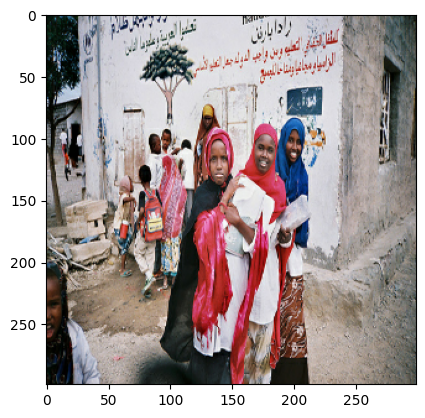

'two women in colorful clothes are standing in front of a brick wall'

In [ ]:
generate_caption(list(valid_data.keys())[155])